<a href="https://colab.research.google.com/github/thanhyx4/Drone-Resupply/blob/main/Project_EC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import copy
import math
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
with open('/content/drive/My Drive/Colab Notebooks/DataPrj_EC/C101_1.5.dat', 'r') as f:
  file1 = []
  for line in f:
    file1.append(line)

#!cat /content/drive/My\ Colab Notebooks/DataPrj_EC/C101_1.5.dat

In [13]:
#N customers, H trucks, K drones, X toa do, Y toa do, D tap kh co the duoc tham boi drone, W - release date


#Read data

In [14]:
def readData(file1):
  num_customers = int(file1[0].split()[1])  - 1       #except depot
  num_trucks = 2
  num_drones = int(file1[2].split()[1])
  listX = []
  listY = []
  W = []
  for i in range(5,5+num_customers):
    line_i = file1[i].split()
    listX.append(line_i[0])
    listY.append(line_i[1])
    W.append(line_i[6])
  return listX, listY, W

X, Y, W = readData(file1)           #
X = np.array(X, dtype=int)
Y = np.array(Y, dtype =int)
W = np.array(W, dtype = int)

# Init Solution

In [15]:
# Hằng số
NUMBER_OF_TRUCKS = 3
NUMBER_OF_DRONES = 3
TRUCK_SPEED = 30  # km/h
DRONE_SPEED = TRUCK_SPEED * 1.5
DRONE_LIMIT_TIME = 15  # phút
N = 6  # Lấy dữ liệu từ dòng số 6
LIMITED_GENS = 50  # Số lượng gen giới hạn

# Lấy mảng chứa các dòng dữ liệu trong file
#lines = file.readFollowingLines(N)
lines = file1[5:]

# Khởi báo các biến
numberOfTrucks = NUMBER_OF_TRUCKS  # số lượng xe tải
numberOfCustomers = len(lines)                                                                          # số lượng khách hàng + 1
numberOfDrones = NUMBER_OF_DRONES  # số lượng drone
customerX = []  # Lưu trữ hoành độ của các khách hàng
customerY = []  # Lưu trữ tung độ của các khách hàng
releaseDate = []  # Lưu thời gian sản phẩm sẵn sàng của các khách hàng
vector = []  # vector nối các depot với các vị trí khách hàng
angles = np.zeros((numberOfCustomers, numberOfCustomers)
                  )  # chứa góc các vector với nhau
# Mảng chứa thời gian bay của drone đến các vị trí khách hàng
# Nếu vị trí khách hàng nằm ngoài khoảng bay được của drone -> gán -1
timeDepotToCusByDrone = []
# mảng chứa tổng thời gian từ depot đến vị trí khách hàng và release date
heuristicTime = [0]
# Trung bình (Thời gian từ depot đến vị trí các khách hàng + release date)
averageOfHeuristicTime = 0
# Mảng chứa vị trí các khách hàng đến thăm của từng xe tải
destination = []
# Mảng chứa điểm đến của các xe tải
truckDestinations = [[]]
# Phương sai
variance = 0
# Mảng chứa các thời gian di chuyển của truck giữa các điểm
timeOfDesToDes = np.zeros((numberOfCustomers, numberOfCustomers))

# Khởi tạo các biến
for line in lines:
    lineNum = line.split()
    customerX.append(int(lineNum[0]))  # customerX[0] : depot
    customerY.append(int(lineNum[1]))
    releaseDate.append(int(lineNum[-1]))
    # khởi tạo vector tạo bởi all data point (include depot point) and depot
    vector.append([customerX[-1] - customerX[0], customerY[-1] - customerY[0]])                       #vector by depot point and all data point (include depot)

# Khởi tạo mảng chứa các thời gian di chuyển của truck giữa các điểm
for i in range(0, numberOfCustomers):
    for j in range(i + 1, numberOfCustomers):
        # Tinh khoang cach theo mahattan
        distance = abs(customerX[i] - customerY[i]) + \
            abs(customerX[j] - customerY[j])
        # t = s / v
        time = distance / TRUCK_SPEED
        timeOfDesToDes[i][j] = timeOfDesToDes[j][i] = time * 60                                     #Truck_time all data point

# khởi tạo mảng chứa thời gian bay của drone
for arr in vector:
    # Tính khoảng cách theo eclip
    distance = math.sqrt(arr[0] * arr[0] + arr[1] * arr[1])
    # Tính thời gian
    time = distance / DRONE_SPEED * 60  # đổi ra phút
    # Kiểm tra giới hạn bay
    if (time <= DRONE_LIMIT_TIME):
        timeDepotToCusByDrone.append(time)
    else:
        timeDepotToCusByDrone.append(-1)                                                          #flying time: include depot to depot

# Khởi tạo mảng các góc giữa các vector


def getAngle(v1, v2):
    numerator = v1[0] * v2[0] + v1[1] * v2[1]
    denominator = math.sqrt(v1[0] * v1[0] + v1[1] * v1[1]) * \
        math.sqrt(v2[0] * v2[0] + v2[1] * v2[1])
    cos = round(numerator/denominator, 10)
    angle = math.degrees(math.acos(cos))
    return angle                                                                  #?tinh cos nay khong the hien duoc goc tu` -> tinh

#0 <=  max_angle <= 180 
# truong hop: max_angle < 180, max_angle = 180 ( 360, < 360)
#objective: tu 1 diem -> xac dinh thu tu cac diem theo 1 vong tron


                                                         # vector[0] = 0 (vector by depot point & itself)
for i in range(1, numberOfCustomers):
    for j in range(i, numberOfCustomers):
        angles[i][j] = getAngle(vector[i], vector[j])
                                                         # matrix angles: angle by customer i and customer j (numberOfCustomer x numberOfCustomer)
        angles[j][i] = angles[i][j]
                                                                   #vector[0], vector[j] = 0

# Khởi tạo mảng chứa thời gian ước lượng từ gốc depot đến vị trí các khách hàng
for i in range(1, numberOfCustomers):
    # append thời gian
    heuristicTime.append(timeOfDesToDes[0][i] + releaseDate[i])
    # tính tổng
    averageOfHeuristicTime += heuristicTime[-1]

# Khời tạo giá trị trung bình
averageOfHeuristicTime /= NUMBER_OF_TRUCKS
# Khởi tạo phương sai
variance = averageOfHeuristicTime / 5

# chuyển đổi list sang array
customerX = np.array(customerX)
customerY = np.array(customerY)
releaseDate = np.array(releaseDate)
vector = np.array(vector)

# Lấy 1 vị trí khách hàng ngẫu nhiên
customerLocation = random.randint(1, numberOfCustomers - 1)

# Lặp từ phần tử đầu đến kế cuối,
# Vì khi đến phần tử cuối là đã sắp xếp thành công


def getCustomerList(arr):
    # Khởi tạo vị trí khách hàng
    location = []
    for i in range(0, numberOfCustomers):
        location.append(i)
    # Hoán đổi vị trí
    for i in range(0, numberOfCustomers):
        for j in range(i + 1, numberOfCustomers):
            if (arr[i] > arr[j]):
                # Hoán đổi giá trị
                tmp = arr[i]
                arr[i] = arr[j]
                arr[j] = tmp
                # hoán đổi vị trí
                tmp = location[i]
                location[i] = location[j]
                location[j] = tmp
    return location


# Sắp xếp vị trí các khách hàng theo góc quay từ bé đến lớn
# angles[7]: list of angles is created by vector(depot, customer_7) and other vectors ???
locations = getCustomerList(angles[customerLocation])
# and then sort them ?
# issue: trường hợp tốt nhất các điểm customer ở xung quanh depot, sắp xếp theo angles giữa 1 điểm và các điểm còn lại thì thứ tự các điểm vẫn bị lộn xộn theo 2 phía của điểm được chọn ban đầu
# -> correct: xây dựng location: xuất phát từ 1 điểm bất kì, điểm tiếp theo  = góc nhỏ nhất giữa điểm đang xét và tất cả các điểm còn lại


# Cập nhật mảng đích đến
count = NUMBER_OF_TRUCKS - 1
lastIndex = 1
for i in range(1, numberOfCustomers):
    if (count > 0):
        sum = 0
        for j in range(lastIndex, i + 1):
            sum += heuristicTime[locations[j]]
        if (abs(sum - averageOfHeuristicTime) <= variance):
            for k in range(lastIndex, i + 1):
                destination.append(locations[k])
            lastIndex = i + 1
            destination.append(-1)
            count -= 1

for k in range(lastIndex, numberOfCustomers):
    destination.append(locations[k])
print(destination)

# Cập nhật mảng 2 chiều chứa các điểm đến của từng xe
for location in destination:
    if (location != -1):
        truckDestinations[-1].append(location)
    else:
        truckDestinations.append([])

print(truckDestinations, '\n')

# # Algorithm
# # Thiết lập mảng chứa các đoạn gen chưa hoàn chỉnh
# subGensTable = []
# for i in range(NUMBER_OF_TRUCKS):
#     subGensTable.append(commonFunc.getAllPermutations(truckDestinations[i]))

# # Thiết lập mảng chứa các gen hoàn chỉnh
# print("=== Bảng gen ===")
# gensTable = []
# for i in range(LIMITED_GENS):
#     # Khởi tạo từng gen
#     gensTable.append([])
#     for subgen in subGensTable:
#         # Lấy ngẫu nhiên 1 đoạn gen
#         randomIndex = random.randint(0, len(subgen) - 1)
#         # Đẩy vào đoạn gen chưa hoàn chỉnh
#         gensTable[-1] += subgen[randomIndex] + [-1]
#     # Loại bỏ -1 ở cuối mảng
#     gensTable[-1].pop()
#     # show từng dòng
#     print(gensTable[-1])

# # Tạo bảng gen mới
# newGensTable = []
# for i in range(LIMITED_GENS):
#     # Lấy ngẫu nhiên 2 gen trong bảng gen
#     nextIndex = random.randint(0, LIMITED_GENS - 1)
#     while (nextIndex == i):
#         nextIndex = random.randint(0, LIMITED_GENS - 1)
#     # Lai ghép tạo gen mới
#     newGens = algorithm.PMX_crossover(
#         gensTable[i], gensTable[nextIndex])
#     newGensTable.append(newGens[0])
#     newGensTable.append(newGens[1])

# print("\n=== Bảng gen mới ===")
# for gen in newGensTable:
#     print(gen)

[3, 5, 4, 2, -1, 6, 7, 1, -1, 9, 8, 10]
[[3, 5, 4, 2], [6, 7, 1], [9, 8, 10]] 



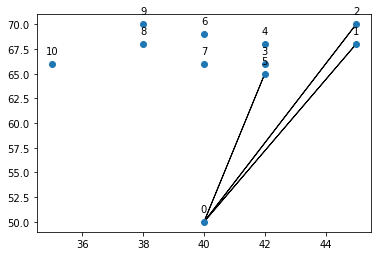

In [16]:
plt.plot(customerX, customerY, 'o')

for i in range(len(customerX)):
    label = i
    plt.annotate(label, # this is the text
                 (customerX[i],customerY[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.arrow(customerX[0], customerY[0], customerX[1] -customerX[0], customerY[1] - customerY[0])
plt.arrow(customerX[0], customerY[0], customerX[2] -customerX[0], customerY[2] - customerY[0])
plt.arrow(customerX[0], customerY[0], customerX[5] -customerX[0], customerY[5] - customerY[0])
plt.show()

# TSP-TW

In [17]:
# print('truck time', timeOfDesToDes)
# print('flying time', timeDepotToCusByDrone[1:])
# print('Ei', type(Ei), Ei)
# print('truck des', truckDestinations)
# print('Ehi', Ehi)
# print('Ehi0', Ehi0)
# print('index_Ehi0', index_Ehi0)

In [18]:
service_time = 0

Tij =  timeOfDesToDes             #the truck travel time
Dj = timeDepotToCusByDrone             #the flying time of drone,
Ei = timeDepotToCusByDrone + releaseDate                 #earliest time at the node i ( Release date + flying time)        #?data points out of drone's zone
              #truong hop Ei = -1 -> chinh flying time of data point which is out of drone's zone -> 0 ???

Ah = truckDestinations            #Ah[h] list customer the truck h need to visit

Ehi = []          # Ehi[h] - list earlist time correspond to list customer Ah[h] ( goc h )
for i in range(len(Ah)):
  Ehi.append( list( Ei[[j for j in Ah[i]]] ) )


#prepare
Ehi0 = copy.deepcopy(Ehi)

for i in range(len(Ehi0)):
  Ehi0[i].sort()
index_Ehi0 = [[]for i in range(NUMBER_OF_TRUCKS)]
for i in range(NUMBER_OF_TRUCKS):
  for j in range(len(Ehi0[i])):
    for k in range(len(Ehi0[i])):                   
      if(Ehi0[i][j] == Ehi[i][k]) and (Ah[i][k] not in index_Ehi0[i] ) :
        index_Ehi0[i].append(Ah[i][k])
        break

# Ti = [[]]
# # Ehi0[h] sorted list, Ehi[h], Ah[h]
# #index_Ehi0[h] la khach hang tuong ung voi Ah[h]
# #service time

# def fitness( Ah):
#   Ti = [[] for i in range(NUMBER_OF_TRUCKS) ]

#   if :
#     Ti[0].append('')

#   #list_customer need to visit and release date and truck_time, flying time btw that points
#   return

# #greedy init
# count = 0
# Ti[0].append(Tij[0,index_Ehi0[0][0]])         #thoi gian truck toi khach hang thu j+ 1: Ti[i][j]
# for q in range(len(Ehi0[0]) - 2):
#   # xet khach hang tiep theo, neu trong kc bay cua drone :
#   qTi[0].append(max(Ti[0][q], Ehi0[0][q]) + service_time + Tij[index_Ehi0[0][q]][index_Ehi0[0][q+1]]  )



In [83]:
def fitness(timeDepotToCusByDrone, timeOfDesToDesByTruck, destination):  #version chưa tính đến gene của drone & số lượng drone (drone resupply tại mọi điểm trong khoảng cách bay)
  #split gene trucks_routing to list truck_routing
  truckDestinations = [[] for i in range(NUMBER_OF_TRUCKS) ]
  tmp=0
  for location in destination:
    if (location != -1):
        truckDestinations[tmp].append(location)
    else:
        tmp += 1
  del tmp

  #
  Dj = timeDepotToCusByDrone
  Tij =  timeOfDesToDesByTruck
  service_time = 0
  index_Ehi0 = copy.deepcopy(truckDestinations)

  #Calculate Time_visit 
  Ti = [[] for i in range(NUMBER_OF_TRUCKS)]
  for truck_i in range(NUMBER_OF_TRUCKS):
    if len(index_Ehi0[truck_i]) == 0:
      Ti[truck_i].append(0)
    else:
      if Dj[index_Ehi0[truck_i][0]] == -1:                                    #check first visit by truck
        i=1
        while ( i < len(index_Ehi0[truck_i])) and (Dj[index_Ehi0[truck_i][i]] == -1)  :
          i = i + 1
        Ti[truck_i].append(np.max(releaseDate[index_Ehi0[truck_i][:i]]) + Tij[0][index_Ehi0[truck_i][0]] )
      else:
        Ti[truck_i].append(Tij[0][index_Ehi0[truck_i][0]])       #khoi tao T0

      for i in range(len(index_Ehi0[truck_i]) - 1 ):               
        #khach hang index_Ehi0[1][i], Ti[i]: thoi gian khach hang toi diem i+1
        if Dj[index_Ehi0[truck_i][i]] == -1:                              #có đường đi của drone: check vị trí đó trên mảng drone
          waitting_time = 0
        else:
          j=1
          while( j < len(index_Ehi0[truck_i])) and  (Dj[index_Ehi0[truck_i][j]] == -1)  :
            j = j + 1 
          waitting_time = np.max(releaseDate[index_Ehi0[truck_i][i+1:j]]) - Ti[truck_i][-1] - service_time
        Ti[truck_i].append(Ti[truck_i][-1] + service_time + waitting_time  + Tij[index_Ehi0[truck_i][i]][index_Ehi0[truck_i][i+1]] )
      #add time truck return to depot
      Ti[truck_i].append(Ti[truck_i][-1] + service_time + Tij[index_Ehi0[truck_i][-1]][0])

#    #Time_visit[0][j]: thoi gian truck 0 đến khach hang thu j+1 trong list khach hang can tham
#    #khởi tạo Time_visit[0][0]:  thời gian truck 0 đến khách hàng thứ 1 trong list khách hàng mình cần đến 
#    #Time_visit[0][j] = Time_visit[0][j-1]  + watting_time_tai_j + service_time + Truck_time[khach_hang_thu_j][khach hang_thu_j+1]   
#    #waitting_time = max(releaseDate của những điểm tiếp theo truck cần phải đến thăm (giữa 2 điểm khách hàng được resupply bởi drone))
#             #giới hạn drone ->waitting_time: + thời gian chờ drone khác bay về depot + thời gian sạc của drone 
  
  #return 60/max(tv[-1] for tv in Ti)       #1/complete_time  (hour)
  return Ti             


In [84]:
print(fitness(timeDepotToCusByDrone, timeOfDesToDes, destination))

[[91.0, 185.0, 283.0, 385.0, 455.0], [138.0, 248.0, 346.0, 412.0], [153.0, 277.0, 399.0, 481.0]]


In [97]:
X = [[10, 9, 8, -1, 7, 6, 4, -1, 5, 3, 1, 2] ,
[10, 9, 8, -1, 7, 4, 6, -1, 1, 2, 5, 3] ,
[10, 8, 9, -1, 7, 6, 4, -1, 5, 1, 2, 3] ,
[9, 8, 10, -1, 7, 6, 4, -1, 5, 2, 1, 3] ,
[10, 8, 9, -1, 4, 7, 6, -1, 5, 2, 1, 3] ,
[9, 10, 8, -1, 6, 7, 4, -1, 5, 2, 1, 3] ,
[8, 10, 9, -1, 7, 6, 4, -1, 5, 2, 3, 1] ,
[9, 10, 8, -1, 7, 6, 4, -1, 1, 3, 5, 2] ,
[8, 9, 10, -1, 4, 7, 6, -1, 3, 2, 1, 5] ,
[9, 8, 10, -1, 4, 6, 7, -1, 5, 2, 3, 1] ,
[10, 8, 9, -1, 4, 7, 6, -1, 3, 2, 5, 1] ,
[9, 8, 10, -1, 6, 7, 4, -1, 2, 5, 3, 1] ,
[9, 8, 10, -1, 4, 6, 7, -1, 3, 1, 2, 5] ,
[10, 9, 8, -1, 7, 6, 4, -1, 5, 3, 1, 2] ,
[8, 9, 10, -1, 4, -1, 7, 6, 3, 1, 2, 5] ,
[9, 8, 10, -1, 4, 7, 6, -1, 5, 2, 1, 3] ,
[8, 10, 9, -1, 4, 7, 6, -1, 2, 1, 3, 5] ,
[8, 10, 9, -1, 7, 6, 4, -1, 3, 1, 2, 5] ,
[8, 10, 9, -1, 6, 7, 4, -1, 2, 5, 1, 3] ,
[10, 9, 8, -1, 4, 7, 6, -1, 5, 3, 1, 2] ,
[10, 8, 9, -1, 7, 6, 4, -1, 3, 5, 1, 2] ,
[10, 8, 9, -1, 7, 6, 4, -1, 2, 1, 3, 5] ,
[9, 10, 8, -1, 6, 7, 4, -1, 5, 2, 1, 3] ,
[10, 9, 8, -1, 4, 7, 6, -1, 3, 2, 1, 5] ,
[9, 8, 10, -1, 4, -1, 7, 6, 3, 1, 5, 2] ,
[9, 8, 10, -1, 7, 6, 4, -1, 5, 1, 2, 3] ,
[8, 10, 9, -1, 6, 4, 7, -1, 2, 1, 3, 5] ,
[9, 8, 10, -1, 7, 6, 4, -1, 2, 3, 5, 1] ,
[8, 9, 10, -1, 7, 6, 4, -1, 1, 5, 2, 3] ,
[8, 10, 9, -1, 4, 6, 7, -1, 2, 1, 3, 5] ,
[10, 9, 8, -1, 4, 7, 6, -1, 2, 3, 1, 5] ,
[9, 10, 8, -1, 6, 7, 4, -1, 5, 1, 2, 3] ,
[10, 8, 9, -1, 7, 4, 6, -1, 5, 2, 1, 3] ,
[9, 8, 10, -1, 7, 6, 4, -1, 5, 3, 1, 2] ,
[10, 9, 8, -1, 7, 6, 4, -1, 1, 3, 5, 2] ,
[9, 10, 8, -1, 7, 6, 4, -1, 5, 3, 1, 2] ,
[10, 9, 8, 1, 7, 6, 4, 1, 5, -1, 3, 2] ,
[8, 10, 9, -1, 7, 6, 4, 2, 1, 3, 5, -1] ,
[10, 8, 9, -1, 6, 7, 4, -1, 2, 5, 3, 1] ,
[10, 8, 9, -1, -1, 6, 4, 7, 2, 5, 1, 3] ,
[8, 9, 10, -1, 6, 7, 4, -1, 5, 3, 2, 1] ,
[8, 9, 10, -1, 7, 6, 4, -1, 3, 5, 2, 1] ,
[9, 10, 8, -1, 4, 6, 7, -1, 1, 3, 2, 5] ,
[8, 9, 10, -1, 6, 7, 4, -1, 2, 3, 1, 5] ,
[8, 9, 10, 7, 4, -1, 6, 7, 2, 5, 1, 3] ,
[9, 8, 10, -1, 4, 7, -1, 6, 3, 1, 2, 5] ,
[10, 9, 8, -1, 6, 4, 7, -1, 5, 2, 1, 3] ,
[9, 10, 8, -1, 4, 6, 7, -1, 2, 5, 1, 3] ,
[10, 2, 9, -1, 7, 6, 4, -1, 5, 8, 1, 3] ,
[10, 9, 3, -1, 7, 6, 4, -1, 5, 2, 1, 8] ,
[8, 10, 9, -1, 4, 7, 6, -1, 3, 5, 1, 2] ,
[10, 9, 8, -1, 4, 6, 7, -1, 1, 3, 5, 2] ,
[9, 4, 10, -1, 6, 7, 8, -1, 3, 5, 2, 1] ,
[10, 8, 9, -1, 6, 4, 7, -1, 2, 5, 3, 1] ,
[9, 8, 10, -1, 6, 7, 4, -1, 5, 2, 1, 3] ,
[10, 9, 8, -1, 4, 7, 6, -1, 3, 5, 2, 1] ,
[9, 10, 8, -1, 6, 4, 7, -1, 5, 1, 2, 3] ,
[10, 9, 8, -1, 4, 6, 7, -1, 2, 5, 1, 3] ,
[10, 9, 8, -1, 4, 6, 7, -1, 5, 1, 2, 3] ,
[8, 9, 10, -1, 4, 7, 6, -1, 3, 5, 1, 2] ,
[9, 8, 10, -1, 3, 4, 7, -1, 5, 6, 2, 1] ,
[8, 9, 10, -1, 6, 7, 4, -1, 2, 3, 5, 1] ,
[10, 8, 9, -1, 4, 2, 6, -1, 5, 3, 1, 7] ,
[8, 9, 10, -1, 7, 4, 6, -1, 5, 2, 1, 3] ,
[9, 10, 8, -1, 6, 7, 4, 2, -1, 3, 5, 1] ,
[8, 9, 10, -1, 4, 6, 7, -1, 5, 1, 3, 2] ,
[8, 9, 10, -1, 7, 6, 4, -1, 3, 5, 1, 2] ,
[10, 9, 8, -1, 4, 7, 6, -1, 3, 2, 5, 1] ,
[8, 9, 10, -1, 6, 4, 7, -1, 3, 5, 2, 1] ,
[9, 8, 5, -1, 7, 6, 4, -1, 2, 3, 10, 1] ,
[8, 9, 10, -1, 7, 6, 4, -1, 3, 2, 5, 1] ,
[8, 9, 10, -1, 4, 6, 7, -1, 5, 1, 2, 3] ,
[9, 8, 5, -1, 6, 4, 7, -1, 3, 2, 10, 1] ,
[9, 10, 8, -1, 7, 6, 4, -1, 2, 3, 5, 1] ,
[10, 8, 9, -1, 7, 6, 4, -1, 5, 2, 1, 3] ,
[8, 10, 9, -1, 7, 4, 6, 2, 5, -1, 3, 1] ,
[10, 8, 9, -1, 7, 6, 4, -1, 3, 1, 2, 5] ,
[9, 8, 10, -1, 6, 4, 7, -1, 3, 1, 2, 5] ,
[8, 9, 10, -1, 4, 6, 7, -1, 2, 3, 1, 5] ,
[8, 5, 10, -1, 4, 7, 6, -1, 1, 9, 2, 3] ,
[8, 9, 10, -1, 4, 7, 6, -1, 2, 3, 1, 5] ,
[9, 8, 10, -1, 4, 7, 6, -1, 3, 2, 5, 1] ,
[8, 10, -1, 9, 6, 7, 4, -1, 3, 5, 1, 2] ,
[8, 9, 10, -1, 7, 4, 6, -1, 2, 3, 1, 5] ,
[8, 9, 10, -1, 4, 7, 6, -1, 5, 2, 1, 3] ,
[9, 8, 10, -1, 7, 4, 6, -1, 2, 3, 5, 1] ,
[8, 10, 9, -1, 6, 4, 7, -1, 1, 2, 3, 5] ,
[9, 10, 3, -1, 7, 6, 4, -1, 8, 5, 2, 1] ,
[8, 10, 9, -1, 4, 6, 7, -1, 1, 5, 3, 2] ,
[8, 10, 9, -1, 7, 6, 4, -1, 2, 1, 3, 5] ,
[9, 10, 8, -1, 7, 6, 4, -1, 3, 5, 2, 1] ,
[10, 9, 8, -1, 4, 6, 7, -1, 5, 2, 1, 3] ,
[9, 10, 8, -1, 4, 6, 7, -1, 1, 3, 5, 2] ,
[10, 9, 8, -1, 7, 4, 6, -1, 5, 2, 1, 3] ,
[9, 8, 10, -1, 4, 6, 7, -1, 1, 3, 2, 5] ,
[8, 10, 9, -1, 6, 7, 4, -1, 2, 1, 3, 5] ,
[10, 8, 9, -1, 4, 6, 7, -1, 2, 1, 3, 5] ,
[8, 10, 9, -1, 7, 4, 6, 1, 5, 2, -1, 3] ,
[10, 9, 8, -1, 7, 4, 6, -1, 2, 5, 1, 3] ,
[9, 8, 10, -1, 7, 4, 6, -1, 5, 3, 1, 2]
]

for i,iter in enumerate(X):
  print(fitness(timeDepotToCusByDrone, timeOfDesToDes, iter))
  print('k bi loi o:', i)

[[151.0, 277.0, 401.0, 481.0], [132.0, 242.0, 352.0, 424.0], [89.0, 183.0, 277.0, 373.0, 443.0]]
k bi loi o: 0
[[151.0, 277.0, 401.0, 481.0], [132.0, 236.0, 346.0, 424.0], [89.0, 185.0, 281.0, 375.0, 443.0]]
k bi loi o: 1
[[151.0, 273.0, 397.0, 481.0], [132.0, 242.0, 352.0, 424.0], [89.0, 181.0, 277.0, 375.0, 443.0]]
k bi loi o: 2
[[153.0, 277.0, 399.0, 481.0], [132.0, 242.0, 352.0, 424.0], [89.0, 185.0, 281.0, 375.0, 443.0]]
k bi loi o: 3
[[151.0, 273.0, 397.0, 481.0], [132.0, 236.0, 346.0, 424.0], [89.0, 185.0, 281.0, 375.0, 443.0]]
k bi loi o: 4
[[153.0, 279.0, 401.0, 481.0], [138.0, 248.0, 352.0, 424.0], [89.0, 185.0, 281.0, 375.0, 443.0]]
k bi loi o: 5
[[149.0, 271.0, 397.0, 481.0], [132.0, 242.0, 352.0, 424.0], [89.0, 185.0, 283.0, 377.0, 443.0]]
k bi loi o: 6
[[153.0, 279.0, 401.0, 481.0], [132.0, 242.0, 352.0, 424.0], [89.0, 183.0, 277.0, 373.0, 443.0]]
k bi loi o: 7
[[149.0, 273.0, 399.0, 481.0], [132.0, 236.0, 346.0, 424.0], [91.0, 189.0, 285.0, 377.0, 443.0]]
k bi loi o: 8
[

In [21]:
  

n=21              #customers
NFT0=0.4
lam=0.001
cnt=10000
t=60
cij=np.array([[0,34,16,38,21,8,11,26,14,28,36,12,23,12,29,30,33,13,32,23,24],
[34,0,33,25,22,30,24,31,20,34,26,22,16,34,8,36,30,30,36,13,18],
[16,33,0,25,31,8,13,39,20,12,23,15,30,5,26,14,19,4,16,20,16],
[38,25,25,0,39,30,27,49,30,15,2,27,34,30,18,16,7,26,13,19,15],
[21,22,31,39,0,24,18,10,11,38,39,16,6,29,22,40,39,27,42,20,25],
[8,30,8,30,24,0,6,31,13,20,28,8,23,5,24,22,25,5,24,18,16],
[11,24,13,27,18,6,0,27,7,22,26,2,17,11,19,24,24,9,26,13,13],
[26,31,39,49,10,31,27,0,21,48,49,26,16,36,32,50,49,35,52,30,35],
[14,20,20,30,11,13,7,21,0,27,29,5,10,18,17,29,29,16,31,12,15],
[28,34,12,15,38,20,22,48,27,0,13,23,36,17,26,2,8,15,4,22,16],
[36,26,23,2,39,28,26,49,29,13,0,26,34,28,19,13,5,24,11,19,14],
[12,22,15,27,16,8,2,26,5,23,26,0,15,13,17,25,25,11,27,11,12],
[23,16,30,34,6,23,17,16,10,36,34,15,0,28,17,38,35,26,39,15,21],
[12,34,5,30,29,5,11,36,18,17,28,13,28,0,27,19,24,4,21,21,18],
[29,8,26,18,22,24,19,32,17,26,19,17,17,27,0,28,22,23,28,6,10],
[30,36,14,16,40,22,24,50,29,2,13,25,38,19,28,0,8,17,3,24,18],
[33,30,19,7,39,25,24,49,29,8,5,25,35,24,22,8,0,20,6,20,14],
[13,30,4,26,27,5,9,35,16,15,24,11,26,4,23,17,20,0,19,17,14],
[32,36,16,13,42,24,26,52,31,4,11,27,39,21,28,3,6,19,0,24,18],
[23,13,20,19,20,18,13,30,12,22,19,11,15,21,6,24,20,17,24,0,6],
[24,18,16,15,25,16,13,35,15,16,14,12,21,18,10,18,14,14,18,6,0]])

                                                                                                          #matrix distances
ei=np.array([0,41,88,132,24,0,0,3,0,112,194,0,69,0,146,105,117,0,130,0,174])            #earliest time
li=np.array([345,183,247,275,137,101,76,155,140,255,308,93,202,106,289,263,264,104,233,122,308])      #latest time of i
li0=np.array([345,183,247,275,137,101,76,155,140,255,308,93,202,106,289,263,264,104,233,122,308])     #latest time
li0.sort()        #sort this array and compare to the previous array to take earliest time



Sx=[]
for j in range(n):
    for k in range(n):
        if(li[k]==li0[j] and k not in Sx):
            Sx.append(k)                #check index cua li0 after sort and append Sx
Sx.remove(0)                      #Sx: list khach hang can den tham

A=[]
c=0
A.append(cij[0,Sx[0]])              #them t/g di tới khach hang đầu tiên vao A, A[q] là thời gian để đi tới khách hàng thứ q
for q in range(n-2 ):
    A.append(max(A[q],ei[Sx[q]])+cij[Sx[q],Sx[q+1]])        #max (A[q], ei[Sx[q]])    thời gian tới điểm đó hoặc thời gian sớm nhất có thể phục vụ tại điểm đó + quãng đường q -> q+1
    if(A[q+1]<=li[Sx[q+1]]):              #nếu thời gian tới q+1 <= latest time ++c
        c=c+1
if(c<19):
    print('initial infeasible solution: {}'.format(Sx))         #check lời giải trong li0 có feasible?


# swapping elements to see for feasibility
B=list(Sx)


for u in range(n-1):
    for v in range(n-1):
        B[u],B[v]=B[v],B[u]                         #swap 2 kh thu u va v
        M=[]
        M.append(cij[0,B[0]])                   #Mi: thoi gian co mat o khach hang thu i+1
        d=0
        for q in range(n-2):
            M.append(max(M[q],ei[B[q]])+cij[B[q],B[q+1]])
            if(M[q+1]<=li[B[q+1]]):
                d=d+1
        if(d<19):                           #kiem tra neu infeasible thi thuc hien
            funct=0
            funct=M[-1]+cij[B[-1],0]+((19-d)*(1+(lam*t))/(NFT0))
            if(funct<cnt):    #neu vi pham thi chac chan co cach di khac co tong thoi gian ngan hon -> sau khi swap tim duoc loi giai thi so sanh voi tong thoi gian cua loi giai cu
                cnt=funct
                O=list(B)
                pi0=list(O)
        if(d==19):            #feasible
            Sl=list(B)
            pi0=list(Sl)
        B=list(Sx)

#initial random solution
#initial random infeasible solutions
print('Initial random feasible solution: {}'.format(pi0))
def calculator(pi):
    N=[]
    N.append(cij[0,pi[0]])
    z=0
    l=len(pi)
    funct=0
    for q in range(l-1):
        N.append(max(N[q],ei[pi[q]])+cij[pi[q],pi[q+1]])
        if(N[q+1]<=li[pi[q+1]]):
            z=z+1
    if(z<19 and l==20):
        funct=N[-1]+cij[pi[-1],0]+((19-z)/(NFT0/(1+(lam*t))))
    if(z==19 and l==20):
        funct=N[-1]+cij[pi[-1],0]
    if(l<20):
        funct=N[-1]
    return(np.array([19-z,funct,z==19]))                        #checking feasibility of initial
print('Checking feasibility of initial random solution by feasibility calculator: {}'.format(calculator(pi0)[-1]==1))


def VNS_1_Opt(pi):
    kmax=2
    k=1
    while(k<=kmax):
        if(k==1):
            pi1=N1(pi)
        if(k==2):
            pi1=N2(pi)
        pr0=calculator(pi)
        pr1=calculator(pi1)
        if( (((pr1[-1]==1)and(pr0[-1]==1))  and(pr1[1]<pr0[1]))    or  ((pr1[-1]==1)and(pr0[-1]==0))   or ((pr1[-1]==0) and(pr0[-1]==0)and(pr1[0]<pr0[0]))  or   ((pr0[-1]==0)and(pr1[-1]==1))   ):
            pi=list(pi1)                #1 feasible and func smaller, 2 pi1 feasible, 3 infeasible and pi1 funct <, duplicate, redundant
        else:
            k=k+1
    return(pi)

def N1(pi):
    for i in range(n-3,1):
        remove=cij[pi[i],pi[i+1]]+c[pi[i-1],pi[i]]-c[pi[i-1],pi[i+1]]
        for j in range(i-1,1):
            add=cij[pi[j-1],pi[i]]+cij[pi[i],pi[j]]-cij[pi[j-1],pi[j]]
            gain=add-remove
            if(gain<0)and(ei[pi[j-1]]+cij[pi[j-1],pi[i]]<=li[pi[i]])            and(ei[pi[i]]+cij[pi[i],pi[j+1]]<=li[pi[j+1]]):
                pi1=list(pi)
                pi1.remove(pi[i])
                pi1.insert(j,pi[i])
                if(calculator(pi1)[1]<calculator(pi)[1]):
                    pi=list(pi1)
    return(pi)
def N2(pi):
    for i in range(1,n-3):
        remove=cij[pi[i-1],pi[i]]+cij[pi[i],pi[i+1]]-cij[pi[i-1],pi[i+1]]
        for j in range(i+1,n-3):
            add=cij[pi[j],pi[i]]+cij[pi[i],pi[j+1]]-cij[pi[j],pi[j+1]]
        gain=add-remove
        if(gain<0)and(ei[pi[i]]+cij[pi[j],pi[i]]<=li[pi[i]])and(ei[pi[i]]+cij[pi[i],pi[j+1]]<=li[pi[j+1]]):
            pi1=list(pi)
            pi1.remove(pi[i])
            pi1.insert(j,pi[i])
            if(calculator(pi1)[1]<calculator(pi)[1]):
                    pi=list(pi1)
    return(pi)
def DestructConstruct(pi,d):
    piR=[]
    piD=[]
    piM=[]
    piX=[]
    piQ=[]
    count=10000
    G=list(pi)
    piR=random.sample(G,d)
    for i in (G):
        if i not in(piR):
            piD.append(i)
    piX=list(piD)
    for x in range(d):
        piM=list(piX)
        for y in range(len(pi)-d):
            piM.insert(y,piR[x])
            if(calculator(piM)[1]<count):
                piQ=list(piM)
                count=calculator(piM)[1]
            piM=list(piX)
            count=10000
        piX=list(piQ)
    if(piX==[]):
        return (piR)
    else:
        return(piX)
kmax=((n-1)/5)
pi=VNS_1_Opt(pi0)
pibest=list(pi)                           #VNS pi0 and store to pibest
k=1
while(k<=kmax):
    d=k*5
    pi1=DestructConstruct(pi,d)                     #destructConstruct pi and then VNS the result
    pi2=VNS_1_Opt(pi1)
    pc=calculator(pi)
    pc2=calculator(pi2)
    pcbest=calculator(pibest)
    if((((pc2[-1]==1)and(pc[-1]==1))        and(pc2[1]<pc[1]))or((pc2[-1]==1)                    and(pc[-1]==0))or((pc2[-1]==0)                                and(pc[-1]==0)                                         and(pc2[0]<pc[0]))or((pc[-1]==0)                                                        and(pc2[-1]==1))):
        k=1
        pi=list(pi2)
        pc=calculator(pi)
        if((((pc[-1]==1)and(pcbest[-1]==1))and(pc[1]<pcbest[1]))or           ((pc[-1]==1)and(pcbest[-1]==0))or((pc[-1]==0)and(pcbest[-1]==0)                                and(pc[0]<pcbest[0]))or((pcbest[-1]==0)and(pc[-1]==1))):
            pibest=list(pi)
    else:
        k=k+1
print('The best solution obtained after VIG algorithm:{}'.format(pibest))
print('The value of the function is: {}'.format(calculator(pibest)[1]))
print(time.clock())



Initial random feasible solution: [6, 11, 5, 17, 13, 19, 4, 8, 7, 1, 12, 18, 2, 9, 15, 16, 3, 14, 10, 20]
Checking feasibility of initial random solution by feasibility calculator: True
The best solution obtained after VIG algorithm:[6, 11, 5, 17, 13, 19, 4, 8, 7, 1, 12, 18, 2, 9, 15, 16, 3, 14, 10, 20]
The value of the function is: 309


AttributeError: ignored

In [ ]:
df = pd.DataFrame([customerX, customerY], index = ['X', 'Y'])
df.T